# Implementation of time blocking for serialization and de-serialization of wavefields with Devito operators

## Introduction 

The goal of this tutorial is to prototype the serialization and de-serialization for wavefields in Devito. The motivation is using seismic modeling operators for full waveform inversion (FWI). Some of the steps in FWI require the re-use of previsouly computed wavefields, in particular the adjoint of the Jacobian linearized operator that maps data perturbation into velocity perturbation requires the wavefield computed with the nonlinear source. 

There are implemented alternatives to serialization / de-serialization like checkpointing (link to nb?), but we are investigating the serialization option here. In order to illustrate the use case for serialization, we write the workflow for computing the gradient of the FWI objective function, ignoring a lot of details, as follows:

1. Generate the nonlinear forward modeled data at the receivers $d_{mod}$
$$ 
d_{mod} = F m 
$$

1. Serialize the nonlinear source wavefield to disk during computation of 1. 

1. Compute the data residual $\delta r$ by differencing observed and modeled data at the receivers 
$$
\delta r = d_{obs} - d_{mod}
$$

1. Backproject the data residual $\delta r$ via time reversal. 

1. De-serialize the nonlinear source wavefield from disk during computation of 4, synchronizing time step between the nonlinear wavefield computed forward in time and time reversed adjoint wavefield. 

1. Increment the model perturbation with a correlation of the de-serialized nonlinear source wavefield and the backprojected receiver adjoint wavefield. Note that this computed model perturbation is the  _gradient_ of the FWI objective function.
$$
\delta m = \bigl( \nabla F\bigr)^\top\ \delta r
$$

The main motivation for this notebook is to show a proof of concept for serialization and de-serialization of the nonlinear wavefield. We will achieve this via _time blocking_: we will run a number of time steps in the generated c kernel, and then return control to python for the serialization and de-serialization operations.

Please see other notebooks in the project for more details, in particular the notebooks describing the self-adjoint modeling operators. More information: 
* Nonlinear operator ([sa_01_iso_implementation1.ipynb](sa_01_iso_implementation1.ipynb))
* Linearized operators ([sa_02_iso_implementation2.ipynb](sa_02_iso_implementation2.ipynb)).

## Outline 
1. Define symbols
1. Description of tests to verify correctness
1. Instantiate the model for a two dimensional problem
1. Time blocking implementation of nonlinear forward
1. Time blocking implementation of Jacobian linearized forward
1. Time blocking implementation of Jacobian linearized adjoint

## Table of symbols

We show the symbols here relevant to the implementation of the linearized operators.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $F[m]\ q$ | Forward linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $q \rightarrow s$ |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |

## Description of tests to verify correctness

In order to make sure we have implemented these operators correctly, we will compare output from two runs:
 - a run with all time steps saved 
 - a run using the time blocking implementation
 
We will design the experiment with a source in the middle of the model and short enough elapsed modeling time that we do not need to worry about boundary reflections for these tests. 

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
from scipy.special import hankel2
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis, Model, AcquisitionGeometry
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.self_adjoint import (acoustic_sa_setup, setup_w_over_q,
                                           SaIsoAcousticWaveSolver)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

## Instantiate the model for a two dimensional problem

Notes:
 - We use a small 400x400 m. model
 - We use 10x10 m. discretization 
 - We do not add an absorbing boundary region for this proof of concept
 - We choose modeling sample rate explicitly (2 msec)
 - We use a modeling time range of 1 second
 - We use a wholespace model
   - velocity: 1500 m/s
   - density: 1 g/cm^3
 - We place the source in the center of the model
 - We use a vertical line of receivers in the center of the model

In [10]:
# Define dimensions for the interior of the model
nx,nz = 401,401
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define the dimensions 
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))

# Initialize the Devito grid 
dtype = np.float64
grid = Grid(extent=extent, shape=shape, origin=origin, dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

# Create velocity and buoyancy fields. 
space_order = 8
v = Function(name='v', grid=grid, space_order=space_order)
b = Function(name='b', grid=grid, space_order=space_order)
v.data[:] = 1.5
b.data[:,:] = 1.0 / 1.0

# Time sampling
t0 = dtype(0)     # Simulation time start
tn = dtype(1000)  # Simulation time end (1 second = 1000 msec)
dt = dtype(2)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("")
print("time_range; ", time_range)

# Source in the center of the model at 10 Hz center frequency
fpeak = 0.010
src = RickerSource(name='src', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[0,0] = dx * (nx//2)
src.coordinates.data[0,1] = dz * (nz//2)

# line of receivers along the right edge of the model
rec = Receiver(name='rec', grid=grid, npoint=nz, time_range=time_range)
rec.coordinates.data[:,0] = dx * (nx//2)
rec.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("")
print("src_coordinate  X;         %+12.4f" % (src.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,0]), np.max(rec.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec.coordinates.data[:,1]), np.max(rec.coordinates.data[:,1])))

shape;            (401, 401)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (4000.0, 4000.0)

grid.shape;       (401, 401)
grid.extent;      (4000.0, 4000.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}

time_range;  TimeAxis: start=0, stop=1000, step=2, num=501

src_coordinate  X;           +2000.0000
src_coordinate  Z;           +2000.0000
rec_coordinates X min/max;   +2000.0000   +2000.0000
rec_coordinates Z min/max;      +0.0000   +4000.0000


## Plot velocity and density models

Next we plot the velocity and density models for illustration. 
- The source is shown as a large red asterisk
- The extent of the receiver array is shown with a thick black line

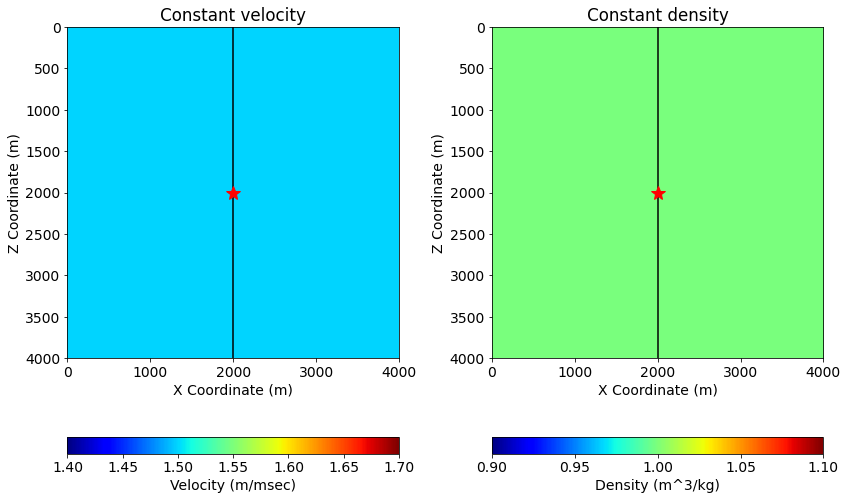

In [12]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin[0], origin[0] + extent[0], origin[1] + extent[1], origin[1]]

vmin, vmax = 1.4, 1.7
dmin, dmax = 0.9, 1.1

plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(m.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant velocity")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Density (m^3/kg)')
plt.plot(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src.coordinates.data[:, 0], src.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant density")

plt.tight_layout()
None

## Time blocking implementation of nonlinear forward



In [ ]:
# NBVAL_IGNORE_OUTPUT

# Setup time / frequency
nt = 1001
dt = 0.1
tmin = 0.0
tmax = dt * (nt - 1)
fpeak = 0.090
t0w = 1.0 / fpeak
omega = 2.0 * np.pi * fpeak
time_axis = TimeAxis(start=tmin, stop=tmax, step=dt)
time = np.linspace(tmin, tmax, nt)

# Model
space_order = 8
npad = 50
dx, dz = 0.5, 0.5
nx, nz = 801, 801
shape = (nx, nz)
spacing = (dx, dz)
origin = (0., 0.)

dtype = np.float64
qmin = 0.1
qmax = 100000
v0 = 1.5*np.ones(shape)
b0 = 1.0*np.ones(shape)

# Model
init_damp = lambda func, nbl: setup_w_over_q(func, omega, qmin, qmax, npad, sigma=0)
model = Model(origin=origin, shape=shape, vp=v0, b=b0, spacing=spacing, nbl=npad,
              space_order=space_order, bcs=init_damp, dtype=dtype, dt=dt)

# Source and reciver coordinates 
src_coords = np.empty((1, 2), dtype=dtype)
rec_coords = np.empty((1, 2), dtype=dtype)
src_coords[:, :] = np.array(model.domain_size) * .5
rec_coords[:, :] = np.array(model.domain_size) * .5 + 60

geometry = AcquisitionGeometry(model, rec_coords, src_coords,
                               t0=0.0, tn=tmax, src_type='Ricker',
                               f0=fpeak)
# Solver setup
solver = SaIsoAcousticWaveSolver(model, geometry, space_order=space_order)

# Numerical solution
recNum, uNum, _ = solver.forward(dt=dt)

# Analytic solution
recAnaPad = analytic_response(fpeak, time_axis, src_coords, rec_coords, model.vp)
recAna = recAnaPad[0:nt]

# Compute RMS and difference
diff = (recNum.data - recAna)
nrms = np.max(np.abs(recNum.data))
arms = np.max(np.abs(recAna))
drms = np.max(np.abs(diff))

print("\nMaximum absolute numerical,analytic,diff; %+12.6e %+12.6e %+12.6e" % (nrms, arms, drms))

# This isnt a very strict tolerance ...
tol = 0.1
assert np.allclose(diff, 0.0, atol=tol)

nmin, nmax = np.min(recNum.data), np.max(recNum.data)
amin, amax = np.min(recAna), np.max(recAna)

print("")
print("Numerical min/max; %+12.6e %+12.6e" % (nmin, nmax))
print("Analytic  min/max; %+12.6e %+12.6e" % (amin, amax))

In [ ]:
# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
assert np.isclose(np.linalg.norm(recAna), 0.0524, atol=0, rtol=1e-3)

## Time blocking implementation of Jacobian linearized forward

blah

## Time blocking implementation of Jacobian linearized adjoint

blah